In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os 
import sys
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
import statistics as stats
from uncertainties import ufloat
import math

In [2]:
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [3]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err', 'z']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 
            'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 'z':z}
df = pd.DataFrame(data_dict)

In [5]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]

df = df.query('z > 0.4 & z <=0.5')

In [7]:
def low_met_agn(df): 
    x_values = df.x.values
    y_values = df.y.values.tolist()
    
    z_1 = df['z'].values
    ha_1 = df['ha'].values
    ha_err_1 = df['ha_err'].values
    hb_1 = df['hb'].values
    hb_err_1 = df['hb_err'].values
    o3_1 = df['o3'].values
    o3_err_1 = df['o3_err'].values
    n2_1 = df['n2'].values
    n2_err_1 = df['n2_err'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df.loc[:,"z"].median())))+1.4+0.03*(df.loc[:,"z"].median())
    
    df = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df.append('agn')
        elif x > 0.0:
            df.append('agn')
        else: 
            df.append('starform')
            
    return df, ha_1, ha_err_1, hb_1, hb_err_1, n2_1, n2_err_1, o3_1, o3_err_1, z_1

In [8]:
df['x'] = np.log10(df['n2']/df['ha'])
df['y'] = np.log10(df['o3']/df['hb'])

df1 = low_met_agn(df)

In [9]:
df1 = pd.DataFrame(df1)
df1 = df1.transpose()
df1.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z']

In [10]:
dfagn = df1[df1.Type != 'starform']
dfsf = df1[df1.Type != 'agn']
dflowmetagn = df1[df1.Type != 'agn']

dfagn = dfagn[dfagn.Type != 'lowmetagn']
dfsf = dfsf[dfsf.Type != 'lowmetagn']
dflowmetagn = dflowmetagn[dflowmetagn.Type != 'starform']

In [11]:
print(len(dfagn))
print(len(dfsf))
print(len(dflowmetagn))

7934
5330
22


In [12]:
dfsf = dfsf.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dfagn = dfagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dflowmetagn = dflowmetagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])

In [13]:
d_MPC = cosmo.luminosity_distance(dflowmetagn['z'])
dflowmetagn['d (MPC)'] = d_MPC

In [14]:
d_MPC = cosmo.luminosity_distance(dfsf['z'])
dfsf['d (MPC)'] = d_MPC

In [15]:
d_MPC = cosmo.luminosity_distance(dfagn['z'])
dfagn['d (MPC)'] = d_MPC

In [16]:
dflowmetagn['d (cm)'] = dflowmetagn['d (MPC)']*3.08567758128E+24
dfsf['d (cm)'] = dfsf['d (MPC)']*3.08567758128E+24
dfagn['d (cm)'] = dfagn['d (MPC)']*3.08567758128E+24

In [17]:
def lumin(oxy3, d_cm):
    L = (oxy3)*(4)*(np.pi)*(d_cm**2)
    return L

In [18]:
dflowmetagn['luminosity_non_bolo'] = lumin(dflowmetagn['o3'], dflowmetagn['d (cm)'])
dfsf['luminosity_non_bolo'] = lumin(dfsf['o3'], dfsf['d (cm)'])
dfagn['luminosity_non_bolo'] = lumin(dfagn['o3'], dfagn['d (cm)'])

In [19]:
dflowmetagn['luminosity_non_bolo'] = dflowmetagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfsf['luminosity_non_bolo'] = dfsf.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfagn['luminosity_non_bolo'] = dfagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

In [20]:
def bolo_lumin(L_o3):
    L_iso_exp = ((0.5617)*(np.log10(L_o3)))+(22.186)
    #L_iso = np.log10(L_iso_exp)
    return L_iso_exp

In [32]:
bolo_non_log_lowmetagn = bolo_lumin(dflowmetagn['luminosity_non_bolo'])
dflowmetagn['log(bolo_lumin)'] = bolo_non_log_lowmetagn
bolo_lumin_lowmetagn = np.log10(bolo_non_log_lowmetagn)
dflowmetagn['Bolo_Lumin'] = bolo_lumin_lowmetagn

dflowmetagn['log(o3_lumin)'] = np.log10(dflowmetagn['luminosity_non_bolo'])
dflowmetagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
487,lowmetagn,930.362,5.45751,0.454208,2525.45,7.79272e+27,7.099691e+59,55.804441,1.746669,59.851239
767,lowmetagn,614.978,4.32836,0.474143,2658.29,8.20262e+27,5.199658e+59,55.728463,1.746077,59.715975
1044,lowmetagn,240.474,2.16501,0.401065,2178.91,6.72342e+27,1.366025e+59,55.402387,1.743528,59.135459
1190,lowmetagn,1011.46,4.06748,0.476445,2673.72,8.25025e+27,8.651521e+59,55.852665,1.747044,59.937092
2779,lowmetagn,681.656,6.10235,0.454491,2527.32,7.79849e+27,5.209501e+59,55.728924,1.746081,59.716796
3379,lowmetagn,1163.45,10.3381,0.443202,2452.76,7.56843e+27,8.374729e+59,55.844733,1.746982,59.922971
3381,lowmetagn,134.203,1.94106,0.449284,2492.87,7.69219e+27,9.978636e+58,55.325778,1.742928,58.999071
3454,lowmetagn,417.684,5.22578,0.446053,2471.54,7.62639e+27,3.052779e+59,55.598553,1.745063,59.484695
3465,lowmetagn,428.796,4.26621,0.446243,2472.79,7.63024e+27,3.137162e+59,55.605205,1.745115,59.496537
3962,lowmetagn,386.322,3.7483,0.460767,2568.98,7.92706e+27,3.050586e+59,55.598378,1.745062,59.484383


In [22]:
bolo_non_log_sf = bolo_lumin(dfsf['luminosity_non_bolo'])
dfsf['log(bolo_lumin)'] = bolo_non_log_sf
bolo_lumin_sf = np.log10(bolo_non_log_sf)
dfsf['Bolo_Lumin'] = bolo_lumin_sf

dfsf['log(o3_lumin)'] = np.log10(dfsf['luminosity_non_bolo'])
dfsf

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
3,starform,3.18538,0.875073,0.416494,2278.36,7.03027e+27,1.978407e+57,54.369340,1.735354,57.296316
4,starform,323.189,4.2039,0.413234,2257.26,6.96519e+27,1.970301e+59,55.491739,1.744228,59.294533
5,starform,8.35742,1.11037,0.476616,2674.87,8.25379e+27,7.154656e+57,54.682923,1.737852,57.854589
6,starform,9.10484,1.26458,0.426982,2346.51,7.24056e+27,5.998280e+57,54.639918,1.737510,57.778027
7,starform,28.0942,1.21983,0.441831,2443.74,7.54059e+27,2.007416e+58,54.934591,1.739846,58.302637
...,...,...,...,...,...,...,...,...,...,...
13281,starform,2.77233,0.555795,0.449668,2495.4,7.70002e+27,2.065564e+57,54.379857,1.735438,57.315039
13282,starform,15.6065,0.989579,0.407869,2222.64,6.85837e+27,9.224778e+57,54.744916,1.738344,57.964956
13283,starform,3.45037,0.821752,0.475013,2664.11,8.22059e+27,2.930099e+57,54.465148,1.736119,57.466882
13284,starform,88.0263,1.36236,0.482934,2717.34,8.38484e+27,7.776998e+58,55.264969,1.742450,58.890812


In [23]:
bolo_non_log_agn = bolo_lumin(dfagn['luminosity_non_bolo'])
dfagn['log(bolo_lumin)'] = bolo_non_log_agn
bolo_lumin_agn = np.log10(bolo_non_log_agn)
dfagn['Bolo_Lumin'] = bolo_lumin_agn

dfagn['log(o3_lumin)'] = np.log10(dfagn['luminosity_non_bolo'])
dfagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
0,agn,19.9635,2.68861,0.48195,2710.71,8.36439e+27,1.755157e+58,54.901832,1.739587,58.244316
1,agn,17.3592,2.33585,0.481997,2711.03,8.36537e+27,1.526542e+58,54.867789,1.739317,58.183709
2,agn,20.9878,2.22232,0.482108,2711.78,8.36768e+27,1.846659e+58,54.914229,1.739685,58.266387
9,agn,23.619,1.42345,0.410082,2236.91,6.90239e+27,1.414067e+58,54.849119,1.739170,58.150470
19,agn,7.91788,1.37746,0.482741,2716.04,8.38083e+27,6.988640e+57,54.677195,1.737806,57.844393
...,...,...,...,...,...,...,...,...,...,...
13267,agn,48.5333,2.03012,0.484613,2728.65,8.41974e+27,4.323616e+58,55.121755,1.741323,58.635847
13268,agn,97.7218,2.67104,0.470961,2636.98,8.13686e+27,8.130465e+58,55.275812,1.742535,58.910115
13269,agn,366.662,3.54711,0.465134,2598.07,8.0168e+27,2.961269e+59,55.591129,1.745005,59.471478
13270,agn,5.46973,1.10341,0.449546,2494.6,7.69754e+27,4.072668e+57,54.545469,1.736759,57.609879


In [24]:
log_bolometric_lowmetagn = dflowmetagn['log(bolo_lumin)']
log_bolometric_sf = dfsf['log(bolo_lumin)']
log_bolometric_agn = dfagn['log(bolo_lumin)']

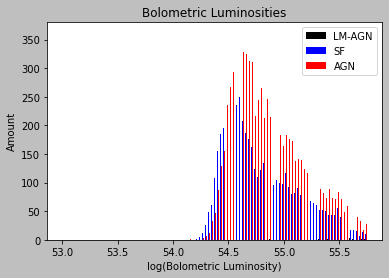

In [25]:
plt.style.use('grayscale')
bins = np.linspace(53, 55.75, 100)
colors = ['k', 'b', 'r']
plt.hist([log_bolometric_lowmetagn, log_bolometric_sf, log_bolometric_agn], bins, label=['LM-AGN', 'SF', 'AGN'], color=colors)

plt.legend(loc='upper right')
plt.title('Bolometric Luminosities')
plt.xlabel('log(Bolometric Luminosity)')
plt.ylabel('Amount')
plt.show()

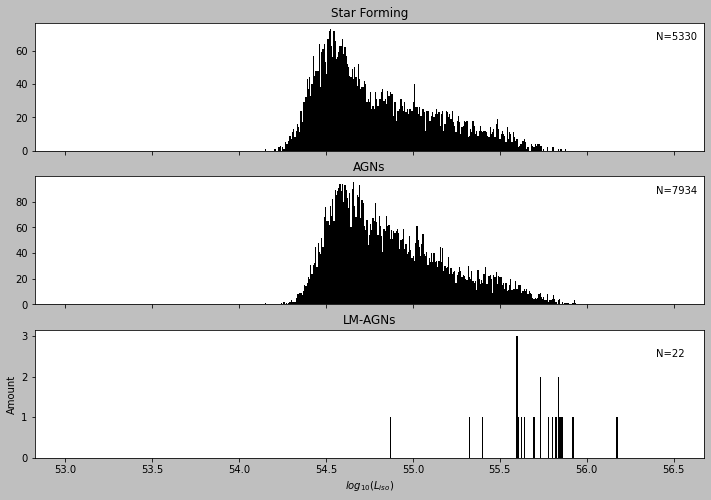

In [39]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(12, 8))
bins = np.linspace(53, 56.5, 500)

sf_hist = axs[0].hist(log_bolometric_sf, bins=bins)
axs[0].set_title('Star Forming')
agn_hist = axs[1].hist(log_bolometric_agn, bins=bins)
axs[1].set_title('AGNs')
lm_agn_hist = axs[2].hist(log_bolometric_lowmetagn, bins=bins)
axs[2].set_title('LM-AGNs')

plt.text(56.4, 10.3, 'N=5330')
plt.text(56.4, 6.5, 'N=7934')
plt.text(56.4, 2.5, 'N=22')

plt.xlabel(r'$log_{10}(L_{iso})$')
plt.ylabel('Amount')
plt.show()

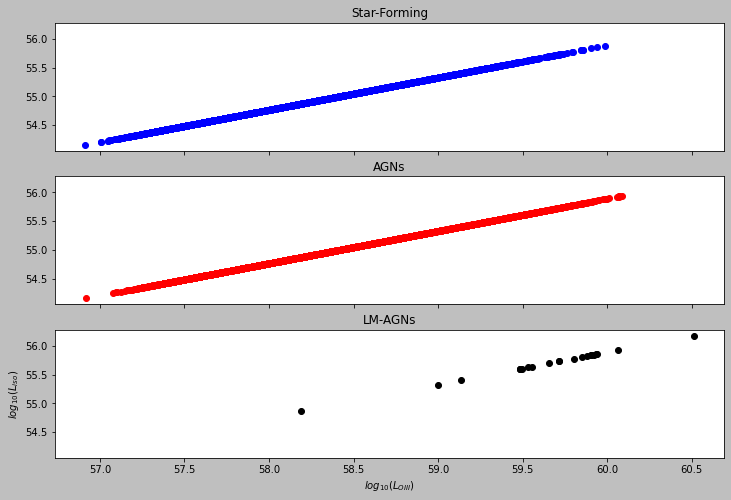

In [27]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(12, 8))

sf_scatter = axs[0].scatter(dfsf['log(o3_lumin)'], dfsf['log(bolo_lumin)'], c='b')
axs[0].set_title('Star-Forming')
agn_scatter = axs[1].scatter(dfagn['log(o3_lumin)'], dfagn['log(bolo_lumin)'], c='r')
axs[1].set_title('AGNs')
lm_agn_scatter = axs[2].scatter(dflowmetagn['log(o3_lumin)'], dflowmetagn['log(bolo_lumin)'], c='k')
axs[2].set_title('LM-AGNs')

plt.ylabel(r'$log_{10}(L_{iso})$')
plt.xlabel(r'$log_{10}(L_{OIII})$')
plt.show()